In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import normaltest
from scipy.special import factorial
from scipy.linalg import solve, det

In [6]:
df = pd.read_csv('CompressedData2021 0101 3112.csv')
df['hour'] = pd.to_datetime(df['Unnamed: 0']*10**6).dt.hour

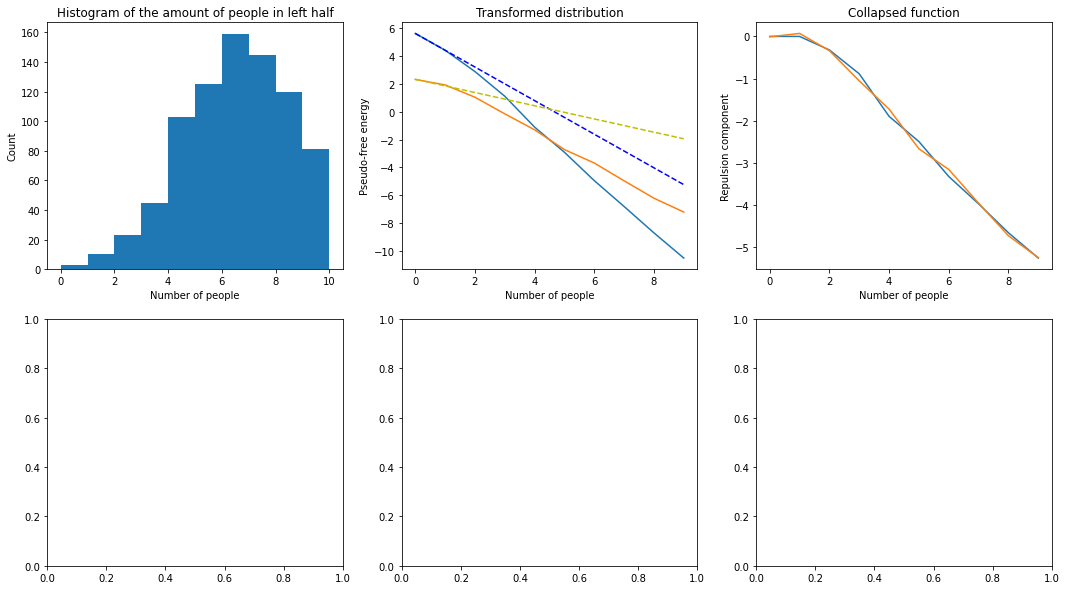

In [91]:
n = 9

l = df[df['N']==n]['p_left'].count()
mn = (df[df['N'] == n]['p_left']*n).mean()

#ax1 = (df[df['N'] == n]['p_right']*n).hist(bins=10)
pb1 = ((df[df['N'] == n]).groupby('p_left').count()['N']/l)
pb2 = ((df[df['N'] == n]).groupby('p_right').count()['N']/l)

x1 = df[df['N'] == n].groupby('p_left').count().index
x2 = df[df['N'] == n].groupby('p_right').count().index

x = np.intersect1d(x1, x2)

tr1 = -np.log(factorial(x*n)*pb1[x])
tr2 = -np.log(factorial(x*n)*pb2[x])

z1 = tr1[0]
z2 = tr2[0]

v1 = (tr1 - z1)/(x[-1]*n) - 1

f_p = tr1[x].to_numpy() - tr2[x].to_numpy()- z1 + z2

v2 = -np.sum(x*n*f_p)/np.sum(x*n*x*n) + v1

fig, ax = plt.subplots(2, 3, figsize=(18, 10))

ax[0,1].plot(x*n, tr1[x])
ax[0,1].plot(x*n, tr2[x])

M = generate_matrix(2)
f = generate_f([tr1, tr2], x)

sol = solve(M.T*M, M.T*f)

ax[0,1].set_xlabel('Number of people')
ax[0,1].set_ylabel('Pseudo-free energy')
ax[0,1].set_title('Transformed distribution')

#ax[0].plot(x, pb1[x]*700)
ax[0,0].hist(df[df['N'] == n]['p_left']*10, bins=10)
ax[0,0].set_xlabel('Number of people')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Histogram of the amount of people in left half')
#ax[0].plot(x*n, pb2[x])

ax[0,2].plot(x*n, tr1[x] - sol[1, 0] - sol[0, 0]*x)
ax[0,2].plot(x*n, tr2[x] - sol[3,0] - sol[2, 0] * x)
ax[0,2].set_xlabel('Number of people')
ax[0,2].set_ylabel('Repulsion component')
ax[0,2].set_title('Collapsed function')

ax[0, 1].plot(x*n, sol[1, 0] + sol[0, 0]* x, 'b--')
ax[0, 1].plot(x*n, sol[3, 0] + sol[2, 0]* x, 'y--')


#ax.plot(-np.log(factorial(x)[:-1]*pb1) + np.log(factorial(x)[:-1]*pb2))

#ax1.plot(l*np.exp(-mn)*mn**x/factorial(x))
fig.savefig('graphs.png')

In [7]:
def generate_matrix(m):

# system:
# (v1 - v2) x(n) + (z1 - z2) = f1(n) - f2(n), for n = 0, 1, 2, 3, 4, 5, ..
# (v2 - v3) x(n) + (z2 - z3) = f2(n) - f3(n), for n = 0, 1, 2, 3, 4, 5, ..
# ..
# (v_{m-1} - v_m) x(n) + (z_{m-1} - z_m) = f_{m-1}(n) - f_m(n)
# z1 = f1(0)
# v1 x(1) + z1 = f1(1)
    Ms = []

    values = np.matrix([[xs, 1, -xs, -1] for xs in x])

    for i in range(m-1):
        M_i = np.matrix(np.zeros((len(x), m*2)))

        mask = np.matrix([[((j >= i*2) and (j < i*2 + 4)) for j in range(m*2)] for _ in x])

        np.place(M_i, mask, values)

        Ms.append(M_i)

    Mcond = np.matrix(np.zeros((2, m*2)))
    Mcond[0, 1] = 1
    #Mcond[1, 2:4] = [1, 1]
    Mcond[1, 0] = 1

    Ms.append(Mcond)

    return np.concatenate(Ms)

def generate_f(trs, x):
    fs = []
    
    for i in range(len(trs)-1):
        fs.append(trs[i].to_numpy().reshape(len(trs[i]), 1) - trs[i+1].to_numpy().reshape(len(trs[i+1]), 1))
        
    fcond = np.array([[trs[0][0]],
                      [(trs[0].iloc[1] - trs[0].iloc[0])/(x[1]-x[0])]])
    #                  [trs[1].iloc[1]]])
    
    fs.append(fcond)
        
    return np.concatenate(fs)
        
f = generate_f([tr1, tr2], x)
M = generate_matrix(2)
solve(M.T * M, M.T * f)[0, 0]

-2.3684757858670005e-15

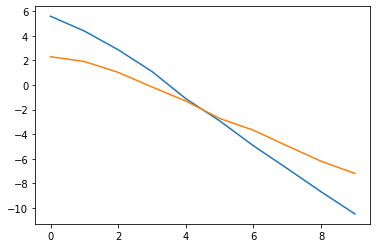

In [94]:
#np.putmask(M_i, mask, values)
M = np.matrix([[xs**i for i in range(len(x))] for xs in x*n])
plt.plot(x*n, M*solve(M, tr1).reshape((10, 1)))
plt.plot(x*n, M*solve(M, tr2).reshape((10, 1)))

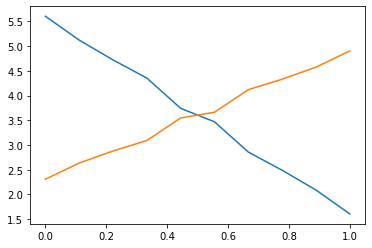

In [100]:
fn = M[:,2:]*solve(M, tr1+tr2)[2:].reshape((8,1))/2

#plt.plot(x, fn)
plt.plot(tr1 - np.array(fn).flatten())
plt.plot(tr2 - np.array(fn).flatten())
#np.std(np.convolve(tr1, np.array([-1,1]))[1:-1]), np.std(np.convolve(tr1 - np.array(fn).flatten(), np.array([-1,1]))[1:-1])

In [89]:
np.convolve(tr1, np.array([-1,1]))[1:-1]

array([0.        , 2.07944154, 2.42036813, 2.14398006, 2.36320971,
       1.84891788, 2.3697244 , 2.1238933 , 1.83431908, 1.96360973,
       1.91019207])